# Explore the Dice Loss

In this notebook we will briefly explore the Dice Loss and show how it's computed.

The Dice Loss is derived from the [Dice-Sorensen Coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) relates the intersection of the predicted area and target area with the union of the predicted area and target area in a very similar manner to the [Intersection over Union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index) loss.

Notation: 
- P: Predicted Area
- T: Target Area
- IoU: Intersection over Union
- DSC: Dice-Sorensen Coeficient

$$
\begin{align*}
    IoU = \frac{|P \cap T|}{|P \cup T|}
    \\ \\
    DSC = \frac{2 |P \cap T|}{|P| + |T|}
\end{align*}
$$

Observing these definitions, we can see that scores for IoU and DSC range from $ 0 \leq (IoU/DSC) \leq 1 $, where 1 indicates a perfect score.

Now that we have formally defined IoU and DSC, let's dive in and take a more intuitive look at what they do.

In [186]:
import numpy as np
import cv2

import matplotlib.pyplot as plt

# get image
image = np.zeros((500, 500, 3), dtype=np.uint8) + 100

tgt_pts = [[250, 100], [350, 250]]
pred_pts = [[200, 125], [325, 275]]
# intersect_pts = [[250, 125], [325, 250]]

# Use opencv to add prediction and target areas
# image = cv2.rectangle(image, tgt_pts[0], tgt_pts[1], (255, 255, 0), thickness=-1) # draw target
# image = cv2.rectangle(image, pred_pts[0], pred_pts[1], (255, 0, 255), thickness=-1) # draw prediction
# image = cv2.rectangle(image, overlap_pts[0], overlap_pts[1], (0, 255, 0), thickness=-1) # draw overlap

# use numpy to slice the areas
image[100:250, 250:350] = [255, 255, 0] # tgt
image[125:275, 200:325] = [255, 0, 255] # prediction
# image[125:250, 250:325] = [0, 255, 0] # intersection

target = image[100:250, 250:350].copy()
prediction = image[125:275, 200:325].copy()
# intersection_ = image[125:250, 250:325].copy()

# compute intersection
y1 = max([tgt_pts[0][1], pred_pts[0][1]])
y2 = max([tgt_pts[0][0], pred_pts[0][0]])

x1 = min([tgt_pts[1][1], pred_pts[1][1]])
x2 = min([tgt_pts[1][0], pred_pts[1][0]])

image[y1:y2, x1:x2] = [0, 255, 0] # intersection
intersection = image[y1:y2, x1:x2].copy()

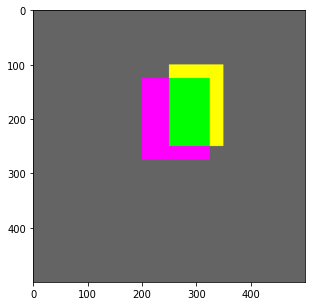

In [189]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(image);

The area of intersection in green is also know as a True Positive (TP), the uncovered target in yellow is known as a False Negative (FN), the incorrect portion of the prediction in magenta is known as a False Positive (FP). If we add the following: 
$$ TP + FN + FP = |P \cup T| = \text{Union} $$

We can also see that the TP is:
$$ TP = |P \cap T| = \text{Intersection} $$

We can now rewrite the IoU and DSC in terms of True Positive, False Negative, and False Positive:

$$
\begin{align*}
    IoU = \frac{TP}{TP + FN + FP}
    \\ \\
    DSC = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}
\end{align*}
$$

The denominator of the DSC comes from the fact that we just add the predicted with the target, this is analgous to the union of the predicted and target plus the intersection:
    
$$ |P \cup T| + |P \cap T| $$



<br>
<br>

Using this information we can compute the [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) of our prediction.

Notation:
- TP: True Positive
- FP: False Positive
- FN: False Negative
- TN: True Negative
$$
\begin{align*}
    \text{Precision} &= \frac{TP}{TP + FP}
    \\ \\
    \text{Recall} &= \frac{TP}{TP + FN}
\end{align*}
$$

<br>
<br>

I use the following mnemonic to help remeber what Precision and Recall actually stand for:
- "Positive Precision" --> Precision is the ratio of True Positive to True and False Positives
- "Real Recall" &emsp; &ensp; &ensp;  --> Recall is the ratio of True Positives to the (combined) number of target values
<br>
$$ |\text{Target Values}| = |TP + FN| $$

This isnt a perfect mnemonic, but it is helpful when starting to use Precision and Recall

<br>
<br>

## How do Precision and Recall relate to the Dice Coefficient?

The Dice-Sorenson Coefficient is actually the [F1-Score](https://en.wikipedia.org/wiki/F-score). The F1 score is the harmonic mean of the Precision and Recall, which means that it provides a measure for both the precision and the recall.

$$
\begin{align*}
    F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = \frac{2 \cdot TP}{2 \cdot TP + FN + FP} = DSC
\end{align*}
$$

The derivation is shown in the appendix

## How do we compute the Dice Loss?

We can compute the Dice Coefficient as:

$$ 
\begin{align}
    DSC = \frac{2 * \sum_j |P \cap T|_j }{\sum_i |P_i| + |T_i| + \epsilon} , \qquad \epsilon > 0
\end{align}
$$

Where $ \epsilon $ prevents division by 0

Remember: $ 0 \leq DSC \leq 1 $, where 1 indicates a perfect score. Most optimizers are equipped for minimization, so we would like to have 0 equal to the perfect score. To do this we simply subtract the DSC from 1:

$$ 
\begin{align}
    \text{Dice Loss} = 1 - DSC 
\end{align}
$$

In [152]:
import torch

N = 3 # number of classes
outputs = torch.randn(1, N, 3, 5)
output_soft = torch.softmax(outputs, dim=1)
predictions = torch.argmax(output_soft, dim=1)

targets = torch.empty(1, 3, 5, dtype=torch.long).random_(N)

print(output_soft)
print(predictions)
print(targets)


tensor([[[[0.1422, 0.1093, 0.5076, 0.6641, 0.6876],
          [0.0994, 0.0593, 0.6191, 0.4130, 0.3638],
          [0.5187, 0.2465, 0.3413, 0.3857, 0.1046]],

         [[0.7981, 0.5505, 0.2023, 0.2478, 0.1289],
          [0.1771, 0.1676, 0.2888, 0.3531, 0.3765],
          [0.2417, 0.0702, 0.4224, 0.3205, 0.0742]],

         [[0.0597, 0.3402, 0.2901, 0.0881, 0.1834],
          [0.7235, 0.7730, 0.0922, 0.2340, 0.2597],
          [0.2396, 0.6834, 0.2363, 0.2938, 0.8212]]]])
tensor([[[1, 1, 0, 0, 0],
         [2, 2, 0, 0, 1],
         [0, 2, 1, 0, 2]]])
tensor([[[0, 2, 0, 0, 2],
         [0, 2, 0, 2, 0],
         [1, 2, 0, 1, 2]]])


In [173]:
# one hot encode the targets
targets_one_hot = torch.zeros_like(output_soft)
for i in range(N):
    targets_one_hot[0, i, targets.squeeze(0) == i] = 1

In [174]:
targets_one_hot

tensor([[[[1., 0., 1., 1., 0.],
          [1., 0., 1., 0., 1.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [1., 0., 0., 1., 0.]],

         [[0., 1., 0., 0., 1.],
          [0., 1., 0., 1., 0.],
          [0., 1., 0., 0., 1.]]]])

In [178]:
intersection = torch.sum(output_soft * targets_one_hot, dim=(1, 2, 3))
cardinality = torch.sum(output_soft + targets_one_hot, dim=(1, 2, 3))

print(intersection)
print(cardinality)

tensor([6.3349])
tensor([30.])


In [179]:
eps = 1e-6
dice_loss = 1 - (2 * intersection / (cardinality + eps))
dice_loss

tensor([0.5777])

In [182]:
def dice_loss(outputs, targets):
    eps = 1e-6

    output_soft = torch.softmax(outputs, dim=1)
    predictions = torch.argmax(output_soft, dim=1)

    # one hot encode the targets
    targets_one_hot = torch.zeros_like(output_soft)
    for i in range(N):
        targets_one_hot[0, i, targets.squeeze(0) == i] = 1

    
    intersection = torch.sum(output_soft * targets_one_hot, dim=(1, 2, 3))
    cardinality = torch.sum(output_soft + targets_one_hot, dim=(1, 2, 3))

    dice_loss = 1 - (2 * intersection / (cardinality + eps))

    return dice_loss

In [181]:
import torchgeometry as tgm
tgm.losses.DiceLoss()(outputs, targets)

tensor(0.5777)

In [109]:
import torch


N = 5 # number of classes
predictions = torch.randn(1, N, 3, 5, requires_grad=True)
targets = torch.empty(1, 3, 5, dtype=torch.long).random_(N)

tgm.losses.DiceLoss()(predictions, targets)

tensor(0.8609, grad_fn=<MeanBackward0>)

In [110]:
predictions.dtype

torch.float32

## Appendix

Relate the F1-score to the Dice-Sorenson Coefficient

$$
\begin{align*}
    F1 &= \frac{2}{\frac{\text{Recall}}{\text{Precision} \cdot \text{Recall}} + \frac{\text{Precision}}{\text{Precision} \cdot \text{Recall}}}
\\
\\
&= 2 \frac{(\text{Precision} \cdot \text{Recall})}{\text{Precision} + \text{Recall}}
\\
\\
&= 2 \frac{\frac{TP}{TP + FP} \cdot \frac{TP}{TP + FN}}{\frac{TP}{TP + FP} + \frac{TP}{TP + FN}}
\\
\\
&= 2 \frac{\frac{TP}{(TP + FP) \cdot (TP + FN)}}{\frac{1}{TP + FP} + \frac{1}{TP + FN}}
\\
\\
&= 2 \frac{\frac{TP}{(TP + FP) \cdot (TP + FN)}}{\frac{(TP + FN) + (TP + FP)}{(TP + FP) \cdot (TP + FN)}}
\\
\\
&= 2 \frac{TP}{(TP + FN) + (TP + FP)}
\\
\\
&= \frac{2 \cdot TP}{2 \cdot TP + FN + FP}
\end{align*}
$$
